In [46]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import random_split
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory
from torchvision.utils import make_grid
import random

In [47]:
# Updated Data Transforms
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(227, scale=(0.8, 1.0)),  # Random crop to 224x224 pixels
        transforms.RandomHorizontalFlip(),  # Randomly flip the image vertically
        transforms.RandomRotation(15),  # Randomly rotate the image by up to 15 degrees
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(227),  # Resize to 227x227 pixels
        transforms.CenterCrop(227),  # Center crop to 227x227 pixels
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(227),  # Resize to 227x227 pixels
        transforms.CenterCrop(227),  # Center crop to 227x227 pixels
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}
data_dir = 'D:\Splitted Curated X-Ray Dataset'

In [48]:
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

print(class_names)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

['COVID-19', 'Normal', 'Pneumonia-Bacterial', 'Pneumonia-Viral']


In [49]:
# Define the path to the train and val folders
train_folder = os.path.join(data_dir, 'train')
val_folder = os.path.join(data_dir, 'val')
test_folder = os.path.join(data_dir, 'test')

# Function to count the number of images in each class folder
def count_images_per_class(folder_path):
    class_counts = {}
    for class_name in os.listdir(folder_path):
        class_path = os.path.join(folder_path, class_name)
        if os.path.isdir(class_path):
            class_count = len(os.listdir(class_path))
            class_counts[class_name] = class_count
    return class_counts

# Print dataset sizes for each class in the training dataset
print("--Training Dataset--")
train_class_counts = count_images_per_class(train_folder)
for class_name, count in train_class_counts.items():
    print(f"{class_name} : {count}")

# Print dataset sizes for each class in the validation dataset
print("\n--Validation Dataset--")
val_class_counts = count_images_per_class(val_folder)
for class_name, count in val_class_counts.items():
    print(f"{class_name} : {count}")

# Print dataset sizes for each class in the test dataset
print("\n--Test Dataset--")
val_class_counts = count_images_per_class(test_folder)
for class_name, count in val_class_counts.items():
    print(f"{class_name} : {count}")

--Training Dataset--
COVID-19 : 1024
Normal : 2616
Pneumonia-Bacterial : 2400
Pneumonia-Viral : 1324

--Validation Dataset--
COVID-19 : 128
Normal : 327
Pneumonia-Bacterial : 300
Pneumonia-Viral : 165

--Test Dataset--
COVID-19 : 129
Normal : 327
Pneumonia-Bacterial : 301
Pneumonia-Viral : 167


In [50]:
import torch

# Check if CUDA (GPU support) is available
if torch.cuda.is_available():
    print("CUDA (GPU) is available.")
    # Get the number of available GPUs
    num_gpus = torch.cuda.device_count()
    print(f"Number of GPUs available: {num_gpus}")
    # Get the name of the current GPU
    current_gpu = torch.cuda.get_device_name(torch.cuda.current_device())
    print(f"Current GPU: {current_gpu}")
else:
    print("CUDA (GPU) is not available. Using CPU.")


CUDA (GPU) is available.
Number of GPUs available: 1
Current GPU: NVIDIA GeForce RTX 3060 Laptop GPU


In [51]:
# def imshow(inp, title=None):
#     """Display image for Tensor."""
#     inp = inp.numpy().transpose((1, 2, 0))
#     mean = np.array([0.485, 0.456, 0.406])
#     std = np.array([0.229, 0.224, 0.225])
#     inp = std * inp + mean
#     inp = np.clip(inp, 0, 1)
#     plt.imshow(inp)
#     if title is not None:
#         plt.title(title)
#     plt.pause(0.001)  # pause a bit so that plots are updated

# # Get a batch of training data
# inputs, classes = next(iter(dataloaders['train']))

# # Make a grid from batch
# out = torchvision.utils.make_grid(inputs)

# imshow(out, title=[class_names[x] for x in classes])

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x00000197878A5BD0>
Traceback (most recent call last):
  File "c:\Users\VICTUS\.conda\envs\skripsi\lib\site-packages\torch\utils\data\dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "c:\Users\VICTUS\.conda\envs\skripsi\lib\site-packages\torch\utils\data\dataloader.py", line 1436, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'


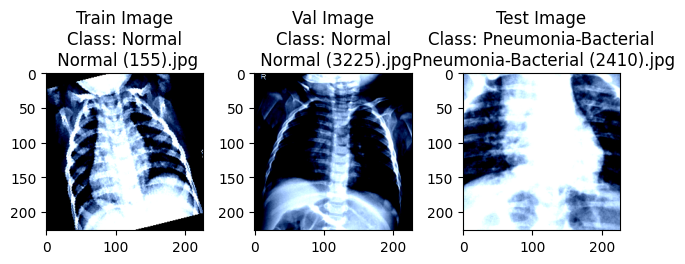

In [52]:
# Randomly select an image from the train dataset
random_train_idx = random.randint(0, len(image_datasets['train']) - 1)
random_train_image, random_train_label = image_datasets['train'][random_train_idx]
random_train_class = class_names[random_train_label]
random_train_image_name = image_datasets['train'].imgs[random_train_idx][0].split("\\")[-1]

# Randomly select an image from the val dataset
random_val_idx = random.randint(0, len(image_datasets['val']) - 1)
random_val_image, random_val_label = image_datasets['val'][random_val_idx]
random_val_class = class_names[random_val_label]
random_val_image_name = image_datasets['val'].imgs[random_val_idx][0].split("\\")[-1]

# Randomly select an image from the test dataset
random_test_idx = random.randint(0, len(image_datasets['test']) - 1)
random_test_image, random_test_label = image_datasets['test'][random_test_idx]
random_test_class = class_names[random_test_label]
random_test_image_name = image_datasets['test'].imgs[random_test_idx][0].split("\\")[-1]

# Convert tensors to numpy arrays for visualization
random_train_image = random_train_image.numpy().transpose((1, 2, 0))
random_val_image = random_val_image.numpy().transpose((1, 2, 0))
random_test_image = random_test_image.numpy().transpose((1, 2, 0))

# Display the train image
plt.subplot(1, 3, 1)
plt.imshow(random_train_image)
plt.title(f"Train Image\nClass: {random_train_class}\n {random_train_image_name}")

# Display the val image
plt.subplot(1, 3, 2)
plt.imshow(random_val_image)
plt.title(f"Val Image\nClass: {random_val_class}\n {random_val_image_name}")


# Display the val image
plt.subplot(1, 3, 3)
plt.imshow(random_test_image)
plt.title(f"Test Image\nClass: {random_test_class}\n {random_test_image_name}")

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

In [53]:
num_classes = 4
model_ft = models.alexnet(weights='IMAGENET1K_V1')

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

from torchsummary import summary
summary(model_ft, (3, 227, 227))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 56, 56]          23,296
              ReLU-2           [-1, 64, 56, 56]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Conv2d-4          [-1, 192, 27, 27]         307,392
              ReLU-5          [-1, 192, 27, 27]               0
         MaxPool2d-6          [-1, 192, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         663,936
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 256, 13, 13]         884,992
             ReLU-10          [-1, 256, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         590,080
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
AdaptiveAvgPool2d-14            [-1, 25

In [54]:
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model

In [55]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [56]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 1.4377 Acc: 0.4599
val Loss: 1.0776 Acc: 0.5141

Epoch 1/24
----------
train Loss: 0.8699 Acc: 0.6513
val Loss: 0.6633 Acc: 0.7283

Epoch 2/24
----------
train Loss: 0.7453 Acc: 0.7059
val Loss: 0.9023 Acc: 0.6554

Epoch 3/24
----------
train Loss: 0.6618 Acc: 0.7298
val Loss: 0.5535 Acc: 0.7543

Epoch 4/24
----------
train Loss: 0.6470 Acc: 0.7455
val Loss: 0.5055 Acc: 0.7989

Epoch 5/24
----------
train Loss: 0.5930 Acc: 0.7629
val Loss: 0.5832 Acc: 0.7783

Epoch 6/24
----------
train Loss: 0.5698 Acc: 0.7728
val Loss: 0.5179 Acc: 0.7707

Epoch 7/24
----------
train Loss: 0.4986 Acc: 0.8024
val Loss: 0.4543 Acc: 0.8152

Epoch 8/24
----------
train Loss: 0.4563 Acc: 0.8068
val Loss: 0.4496 Acc: 0.8239

Epoch 9/24
----------
train Loss: 0.4588 Acc: 0.8110
val Loss: 0.4380 Acc: 0.8261

Epoch 10/24
----------
train Loss: 0.4411 Acc: 0.8229
val Loss: 0.4275 Acc: 0.8261

Epoch 11/24
----------
train Loss: 0.4417 Acc: 0.8187
val Loss: 0.4276 Acc: 0.8315

Ep

In [57]:
torch.save(model_ft, 'D:/UNAIR/SKRIPSI/Seminar Proposal/FIX/Kodingan/Saved Model/AlexNet_with_Aug.pth') # Save The Model
# model_ft = models.alexnet() # Load Model
# model_ft.load_state_dict(torch.load('D:/UNAIR/SKRIPSI/Seminar Proposal/FIX/Kodingan/Saved Model/AlexNet_with_Aug.pth')) # Load Model
# model_ft.eval() # Load Model

In [58]:
print(model_ft)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

c:\Users\VICTUS\.conda\envs\skripsi\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


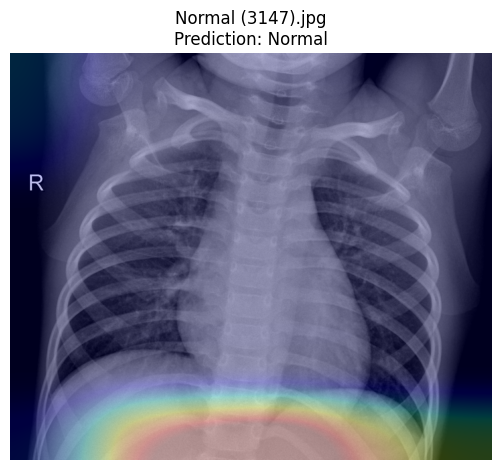

In [59]:
from torchvision.io.image import read_image
from torchvision.transforms.functional import normalize, resize, to_pil_image
import matplotlib.pyplot as plt
from torchcam.utils import overlay_mask

def viz_cam():

    # Define your model (Assuming 'model_ft' is defined somewhere in your code)
    model = model_ft.eval()

    # Set your CAM extractor
    from torchcam.methods import ScoreCAM
    cam_extractor = ScoreCAM(model,'classifier','fc')

    # Select a random image from the specified dataset
    random_image_index = random.randint(0, len(image_datasets['test']) - 1)
    img_path = image_datasets['test'].imgs[random_image_index][0]
    img_name = image_datasets['test'].imgs[random_image_index][0].split("\\")[-1]

    img = read_image(img_path)
    # Preprocess it for your chosen model
    input_tensor = normalize(resize(img, (227, 227)) / 255., [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

    # Move the input tensor to the GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    input_tensor = input_tensor.to(device)

    with ScoreCAM(model) as cam_extractor:
        # Preprocess your data and feed it to the model
        out = model(input_tensor.unsqueeze(0))
        # Get the predicted class index
        predicted_class_index = out.squeeze(0).argmax().item()
        # Retrieve the CAM by passing the class index and the model output
        activation_map = cam_extractor(out.squeeze(0).argmax().item(), out)

    predicted_class = class_names[predicted_class_index]

    # Resize the CAM and overlay it
    result = overlay_mask(to_pil_image(img), to_pil_image(activation_map[0].squeeze(0), mode='F'), alpha=0.75)

    # Display it with title and prediction
    plt.imshow(result)
    plt.title(f"{img_name}\nPrediction: {predicted_class}")
    plt.axis('off')
    plt.tight_layout()
    plt.show()

viz_cam()

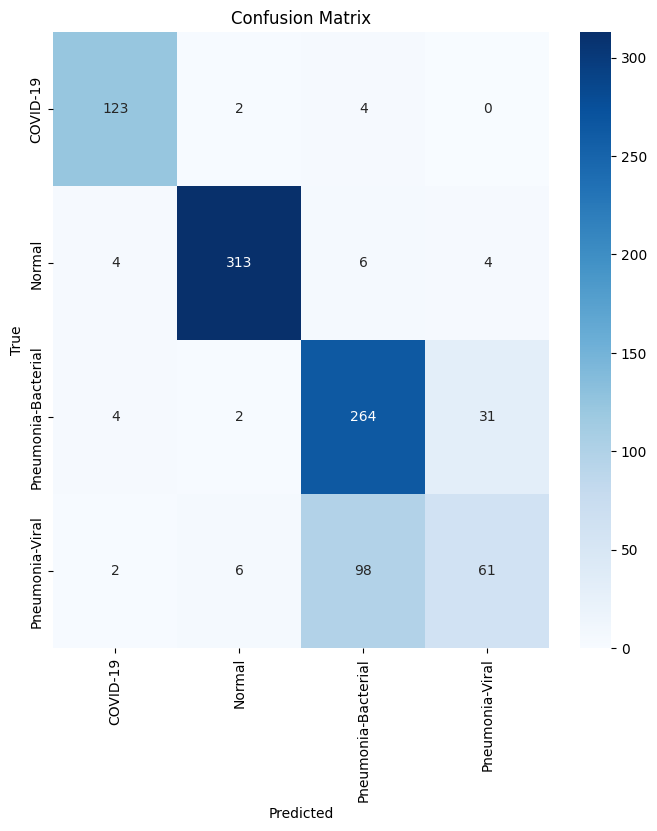

In [60]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

def generate_confusion_matrix(model, dataloader, device):
    model.eval()

    true_labels = []
    predicted_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())

    # Create the confusion matrix
    conf_matrix = confusion_matrix(true_labels, predicted_labels)
    
    return conf_matrix

# Assuming 'model_ft' is already defined and loaded with the appropriate weights
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
conf_matrix = generate_confusion_matrix(model_ft, dataloaders['test'], device)

# Plot the confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [61]:
from sklearn.metrics import classification_report
# Evaluate on the test set using the best model
model_ft.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model_ft(inputs)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Generate and print the classification report
report = classification_report(all_labels, all_preds, target_names=class_names, digits=4)
print("Classification Report:\n", report)

Classification Report:
                      precision    recall  f1-score   support

           COVID-19     0.9248    0.9535    0.9389       129
             Normal     0.9690    0.9572    0.9631       327
Pneumonia-Bacterial     0.7097    0.8771    0.7845       301
    Pneumonia-Viral     0.6354    0.3653    0.4639       167

           accuracy                         0.8236       924
          macro avg     0.8097    0.7883    0.7876       924
       weighted avg     0.8181    0.8236    0.8113       924



In [62]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F

def evaluate_auc_roc(model, dataloader, num_classes, class_names):
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            probabilities = F.softmax(outputs, dim=1)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(probabilities.cpu().numpy())

    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(all_labels == i, all_preds[:, i])
        roc_auc[i] = roc_auc_score(all_labels == i, all_preds[:, i])

 # Plot ROC curve
    plt.figure(figsize=(8, 6))
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], label=f'{class_names[i]} (AUROC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (1-Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity)')
    plt.title('AUC-ROC Curve for Multi-Class Classification')
    plt.legend(loc="lower right")
    plt.show()


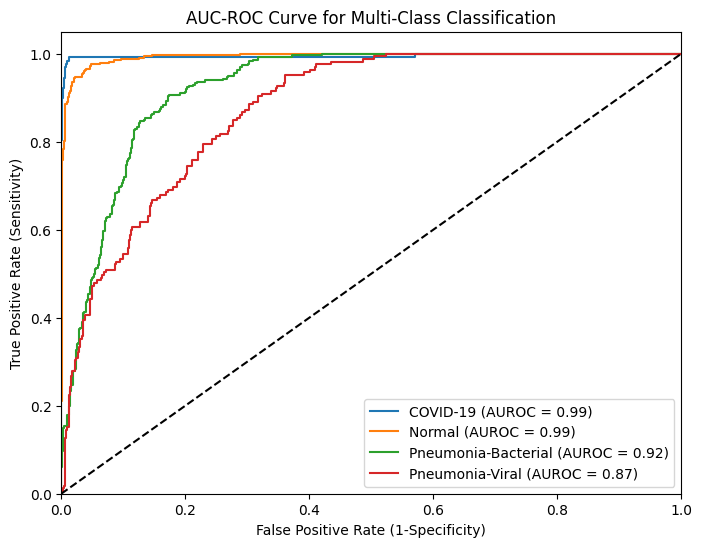

In [63]:
class_names = ['COVID-19', 'Normal', 'Pneumonia-Bacterial', 'Pneumonia-Viral']
evaluate_auc_roc(model_ft, dataloaders['val'], num_classes, class_names)